So sánh kết quả phương pháp và ground truth trên tập dữ liệu nhỏ (46 ảnh)

In [ ]:
import os
import glob
import cv2
import numpy as np

In [ ]:
def precision(TP: int, FP: int) -> float:
    epsilon = 1e-7
    return TP / (TP + FP + epsilon)

def recall(TP: int, FN: int) -> float:
    epsilon = 1e-7
    return TP / (TP + FN + epsilon)

def f1_score(precision: float, recall: float) -> float:
    if (precision + recall) == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

In [3]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    return iou

In [5]:
# Từ file txt thành masks
def txt_masks(file_path, size=640):
    masks = []
    if not os.path.exists(file_path):
        return masks

    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5: continue

        coords = np.array([float(x) for x in parts[1:]])
        points = coords.reshape(-1, 2)

        points[:, 0] *= size
        points[:, 1] *= size
        points = points.astype(np.int32)

        mask = np.zeros((size, size), dtype=np.uint8)
        cv2.fillPoly(mask, [points], 1)
        masks.append(mask)

    return masks

In [ ]:
# Tính kết quả từng ảnh
def evaluate_file(gt_path, pred_path, iou_thresh=0.5):
    gt_masks = txt_masks(gt_path)    # List các mask Ground Truth
    pred_masks = txt_masks(pred_path) # List các mask Prediction

    tp = 0 #true positive
    iou_sum = 0

    # Đánh dấu những mask đã được ghép cặp để không dùng lại
    gt_matched = [False] * len(gt_masks)
    pred_matched = [False] * len(pred_masks)

    # Tính tất cả các cặp IoU có thể xảy ra
    matches = []
    for i, gt_m in enumerate(gt_masks):
        for j, pred_m in enumerate(pred_masks):
            iou = calculate_iou(gt_m, pred_m)
            if iou >= iou_thresh:
                matches.append((iou, i, j))

    #  Sắp xếp giảm dần theo IoU
    matches.sort(key=lambda x: x[0], reverse=True)

    #  Duyệt và ghép cặp
    for iou, gt_idx, pred_idx in matches:
        # Nếu cả GT và Pred này đều chưa ai lấy
        if not gt_matched[gt_idx] and not pred_matched[pred_idx]:
            tp += 1
            iou_sum += iou
            # Đánh dấu là đã dùng
            gt_matched[gt_idx] = True
            pred_matched[pred_idx] = True

    # 5. Tính FP, FN, mIoU
    n_gt = len(gt_masks)
    n_pred = len(pred_masks)

    fp = n_pred - tp  # Pred có mà không ghép được GT nào -> Báo thừa
    fn = n_gt - tp    # GT có mà không ghép được Pred nào -> Bỏ sót

    # mIoU chỉ tính trên những cặp TP đúng
    miou = iou_sum / tp if tp > 0 else 0

    return miou, tp, fp, fn

In [ ]:
# Tính tổng dữ liệu
def evaluate_dataset(gt_folder, pred_folder, iou_thresh=0.5):
    gt_files = glob.glob(os.path.join(gt_folder, "*.txt"))

    if len(gt_files) == 0:
        return

    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_matched_iou = 0.0

    for gt_path in gt_files :
        filename = os.path.basename(gt_path)
        pred_path = os.path.join(pred_folder, filename)

        iou, tp, fp, fn = evaluate_file(gt_path, pred_path, iou_thresh)

        total_tp += tp
        total_fp += fp
        total_fn += fn
        total_matched_iou += iou

    # Precision:
    p = precision(total_tp,total_fp)

    # Recall:
    r = recall(total_tp,total_fn)

    # F1-Score:
    f1 = f1_score(p,r)

    # mIoU:
    m_iou = total_matched_iou / len(gt_files)

    print(f"IOU THRESHOLD = {iou_thresh}")
    #print(f"Tổng số file ảnh: {len(gt_files)}")
    #print(f"True Positives (TP):   {total_tp} ")
    #print(f"False Positives (FP):  {total_fp} ")
    #print(f"False Negatives (FN):  {total_fn} ")
    print(f" Precision: {p:.4f}")
    print(f" Recall: {r:.4f}")
    print(f" F1-Score: {f1:.4f}")
    print(f" m_IoU:{m_iou:.4f} ")

In [8]:
GT_DIR = '/home/tdh/Segment/data/model_pred/labels/train/'
PRED_DIR = '/home/tdh/Segment/data/model_pred/tiny/labels/train/gt_images/'

for i in range(5,10) :
    evaluate_dataset(GT_DIR, PRED_DIR, iou_thresh=i/10)

IOU THRESHOLD = 0.5
 Precision: 0.8669
 Recall: 0.7139
 F1-Score: 0.7830
 m_IoU:0.8786 
IOU THRESHOLD = 0.6
 Precision: 0.8418
 Recall: 0.6933
 F1-Score: 0.7604
 m_IoU:0.8882 
IOU THRESHOLD = 0.7
 Precision: 0.8128
 Recall: 0.6694
 F1-Score: 0.7342
 m_IoU:0.8971 
IOU THRESHOLD = 0.8
 Precision: 0.7447
 Recall: 0.6134
 F1-Score: 0.6727
 m_IoU:0.9092 
IOU THRESHOLD = 0.9
 Precision: 0.4925
 Recall: 0.4056
 F1-Score: 0.4448
 m_IoU:0.9332 


In [9]:
GT_DIR = '/home/tdh/Segment/data/model_pred/labels/train/'
PRED_DIR = '/home/tdh/Segment/data/model_pred/quan_tiny/labels/train/gt_images/'

for i in range(5,10) :
    evaluate_dataset(GT_DIR, PRED_DIR, iou_thresh=i/10)

IOU THRESHOLD = 0.5
 Precision: 0.8538
 Recall: 0.6983
 F1-Score: 0.7683
 m_IoU:0.8589 
IOU THRESHOLD = 0.6
 Precision: 0.8337
 Recall: 0.6818
 F1-Score: 0.7501
 m_IoU:0.8658 
IOU THRESHOLD = 0.7
 Precision: 0.8044
 Recall: 0.6579
 F1-Score: 0.7238
 m_IoU:0.8757 
IOU THRESHOLD = 0.8
 Precision: 0.7409
 Recall: 0.6059
 F1-Score: 0.6667
 m_IoU:0.8868 
IOU THRESHOLD = 0.9
 Precision: 0.4839
 Recall: 0.3957
 F1-Score: 0.4354
 m_IoU:0.9121 


In [10]:
GT_DIR = '/home/tdh/Segment/data/model_pred/labels/train/'
PRED_DIR = '/home/tdh/Segment/data/model_pred/quan_l/labels/train/gt_images/'

for i in range(5,10) :
    evaluate_dataset(GT_DIR, PRED_DIR, iou_thresh=i/10)

IOU THRESHOLD = 0.5
 Precision: 0.8827
 Recall: 0.7321
 F1-Score: 0.8004
 m_IoU:0.8864 
IOU THRESHOLD = 0.6
 Precision: 0.8588
 Recall: 0.7123
 F1-Score: 0.7787
 m_IoU:0.8959 
IOU THRESHOLD = 0.7
 Precision: 0.8370
 Recall: 0.6941
 F1-Score: 0.7589
 m_IoU:0.9024 
IOU THRESHOLD = 0.8
 Precision: 0.7903
 Recall: 0.6554
 F1-Score: 0.7165
 m_IoU:0.9108 
IOU THRESHOLD = 0.9
 Precision: 0.5189
 Recall: 0.4303
 F1-Score: 0.4705
 m_IoU:0.9347 


In [11]:
GT_DIR = '/home/tdh/Segment/data/model_pred/labels/train/'
PRED_DIR = '/home/tdh/Segment/data/model_pred/large/labels/train/gt_images/'

for i in range(5,10) :
    evaluate_dataset(GT_DIR, PRED_DIR, iou_thresh=i/10)

IOU THRESHOLD = 0.5
 Precision: 0.8850
 Recall: 0.7362
 F1-Score: 0.8038
 m_IoU:0.8878 
IOU THRESHOLD = 0.6
 Precision: 0.8612
 Recall: 0.7164
 F1-Score: 0.7822
 m_IoU:0.8968 
IOU THRESHOLD = 0.7
 Precision: 0.8375
 Recall: 0.6966
 F1-Score: 0.7606
 m_IoU:0.9032 
IOU THRESHOLD = 0.8
 Precision: 0.7899
 Recall: 0.6570
 F1-Score: 0.7174
 m_IoU:0.9120 
IOU THRESHOLD = 0.9
 Precision: 0.5292
 Recall: 0.4402
 F1-Score: 0.4806
 m_IoU:0.9350 


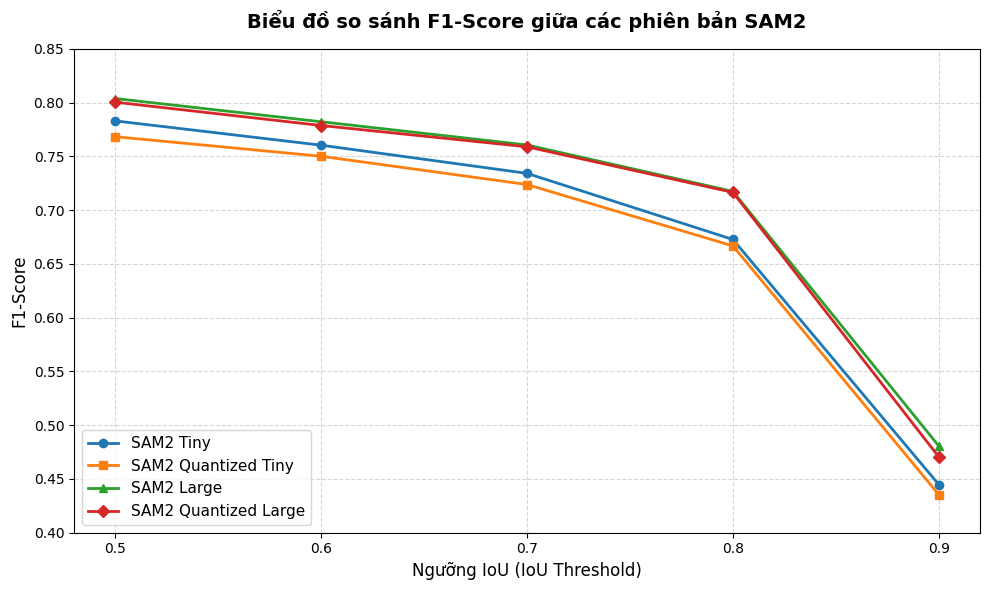

In [ ]:
import matplotlib.pyplot as plt

iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

f1_scores = {
    "SAM2 Tiny": [0.7830, 0.7604, 0.7342, 0.6727, 0.4448],
    "SAM2 Quantized Tiny": [0.7683, 0.7501, 0.7238, 0.6667, 0.4354],
    "SAM2 Large": [0.8038, 0.7822, 0.7606, 0.7174, 0.4806],
    "SAM2 Quantized Large": [0.8004, 0.7787, 0.7589, 0.7165, 0.4705]
}

plt.figure(figsize=(10, 6))

markers = ['o', 's', '^', 'D']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (name, scores) in enumerate(f1_scores.items()):
    plt.plot(iou_thresholds, scores,
             marker=markers[i],
             label=name,
             linewidth=2,
             color=colors[i])

plt.title('Biểu đồ so sánh F1-Score giữa các phiên bản SAM2', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Ngưỡng IoU (IoU Threshold)', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(iou_thresholds)
plt.ylim(0.4, 0.85)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11, loc='lower left')
plt.tight_layout()
plt.show()